<a id="title_ID"></a>
# Beginner: Read and Plot A K2 Light Curve File

This notebook tutorial demonstrates how to load and plot the contents of a K2 light curve (lc) file.  We will plot the flux timeseries contained within the file, and display which pixels were used in the photometric aperture.

In [1]:
%matplotlib inline
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np

## Introduction

A light curve is a plot of flux versus time, and is used to identify variability, including the transits of orbiting companions like planets.  The light curve shown here will be for the star TRAPPIST-1 (the K2 ID for the standard readout is EPIC 246199087, a larger readout for this star was also obtained with a K2 ID of EPIC 200164267).  TRAPPIST-1 is known to host a system of seven Earth-sized planets.

This tutorial will refer to a couple K2-related terms that we define here.
* Campaign = During the K2 mission, the Kepler telescope observed the sky in a given pointing along the ecliptic plane for approximately 80 days at a time.  Each of these regions is referred to as a "Campaign", starting with Campaign 0 and ending with Campaign 19. There was also a special "Engineering" Campaign before Campaign 0 that lasted ~10 days.
* HDU = Header Data Unit.  A FITS file is made up of HDUs that contain data and metadata relating to the file. The first HDU is called the primary HDU, and anything that follows is considered an "extension", e.g., "the first FITS extension", "the second FITS extension", etc.
* BJD = Barycentric Julian Date, the Julian Date that has been corrected for differences in the Earth's position with respect to the Solar System center of mass.
* BKJD =  Barycentric Kepler Julian Date, the timestamp measured in BJD, but offset by 2454833.0.  I.e., BKJD = BJD - 2454833.0
* WCS = World Coordinate System, A FITS convention used to store coordinate information inside FITS headers.  For K2 full frame images, it is used to provide the translation needed to go from pixel coorindates to celestial coordinates in right ascension and declination.
* SAP Flux = Simple Aperture Photometry flux, the flux after summing the calibrated pixels within the K2 optimal photometric aperture.
* PDCSAP Flux = Pre-search Data Conditioned Simple Aperture Photometry, the SAP flux values nominally corrected for instrumental variations.  Thus, these fluxes are the mission's best estimate of the intrinsic variability of the target.

## Obtaining The Light Curve File

We will read the light curve file from Campaign 12 using the MAST URL location.  So that we can get started with understanding the file contents without reviewing how to automatically search for and retrieve K2 files, we won't show how to search and retrieve K2 light curve files in this tutorial.

In [2]:
# For the purposes of this tutorial, we just know the MAST URL location of the file we want to examine.
fits_file = "https://archive.stsci.edu/missions/k2/lightcurves/c12/246100000/99000/ktwo246199087-c12_llc.fits"

## Understanding The Light Curve FITS File Structure

K2 light curve FITS files contain a primary HDU with metadata stored in the header.  The first extension HDU contains more metadata in the header, and stores arrays of data in a binary FITS table, which include the timestamps, SAP fluxes, and PDCSAP fluxes.  The second extension HDU consists of an image that contains the collected pixels for this target, and records information about them, such as which of those pixels were used in the optimal photometric aperture to create the SAP fluxes.  Let's examine the structure of the FITS file using the astropy.fits `info` function, which shows the FITS file format in more detail.

In [3]:
fits.info(fits_file)

Filename: /root/.astropy/cache/download/py3/09cf6b1dda3820e10ff666ddb57a18b3
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      54   ()      
  1  LIGHTCURVE    1 BinTableHDU    155   3862R x 20C   [D, E, J, E, E, E, E, E, E, J, D, E, D, E, D, E, D, E, E, E]   
  2  APERTURE      1 ImageHDU        48   (10, 9)   int32   


Let's examine the binary table in the first FITS extension, since that contains the arrays of timestamps and fluxes we want to plot.  We will use the astropy.fits `getdata` function to access the table from the first extension HDU, and then show the columns of the table.  We can see that the table includes columns for the timestamps in Kepler BJD format (**TIME**), SAP flux (**SAP_FLUX**), and PDCSAP flux (**PDCSAP_FLUX**).

In [4]:
fits.getdata(fits_file, ext=1).columns

ColDefs(
    name = 'TIME'; format = 'D'; unit = 'BJD - 2454833'; disp = 'D14.7'
    name = 'TIMECORR'; format = 'E'; unit = 'd'; disp = 'E13.6'
    name = 'CADENCENO'; format = 'J'; disp = 'I10'
    name = 'SAP_FLUX'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'SAP_FLUX_ERR'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'SAP_BKG'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'SAP_BKG_ERR'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'PDCSAP_FLUX'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'PDCSAP_FLUX_ERR'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'SAP_QUALITY'; format = 'J'; disp = 'B16.16'
    name = 'PSF_CENTR1'; format = 'D'; unit = 'pixel'; disp = 'F10.5'
    name = 'PSF_CENTR1_ERR'; format = 'E'; unit = 'pixel'; disp = 'E14.7'
    name = 'PSF_CENTR2'; format = 'D'; unit = 'pixel'; disp = 'F10.5'
    name = 'PSF_CENTR2_ERR'; format = 'E'; unit = 'pixel'; disp = 'E14.7'
    name = 'MOM_CENTR1'; format = 'D'; uni

## Reading the timestamps and fluxes.

Now that we have the light curve file, let's store the timestamps and fluxes as arrays for use later.

In [5]:
with fits.open(fits_file, mode="readonly") as hdulist:
    k2_bjds = hdulist[1].data['TIME']
    sap_fluxes = hdulist[1].data['SAP_FLUX']
    pdcsap_fluxes = hdulist[1].data['PDCSAP_FLUX']

## Plot the light curve.

Let's make a plot of the PDCSAP flux vs. time in Kepler BJD.

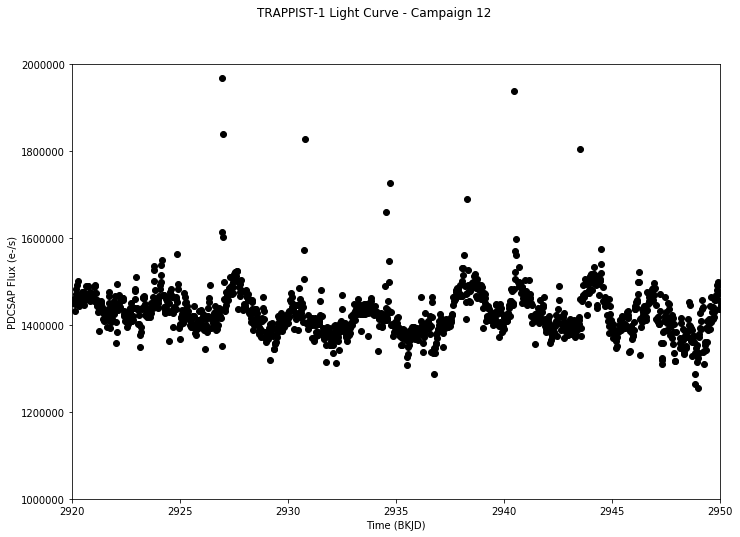

In [6]:
# Start figure and axis.
fig, ax = plt.subplots()
fig.set_size_inches(12., 8.)

# Plot the timeseries in black circles.
ax.plot(k2_bjds, pdcsap_fluxes, 'ko')

# Let's label the axes and define a title for the figure.
fig.suptitle("TRAPPIST-1 Light Curve - Campaign 12")
ax.set_ylabel("PDCSAP Flux (e-/s)")
ax.set_xlabel("Time (BKJD)")

# Let's zoom in on the x-axis and y-axis.  We can see a sinusoidal pattern due to starspots.
# The transits are in there too, but you'd need to clean the light curve before you see them.
ax.set_xlim(2920., 2950.)
ax.set_ylim(0.1e7, 0.2e7)

# Adjust the left margin so the y-axis label shows up.
plt.subplots_adjust(left=0.15)
plt.show()

## Understanding Light Curve Flags

The table of information contains more than just timestamps and fluxes.  In particular, there is a column of flags associated with every timestamp that indicate a number of warnings and conditions associated with that measurement.  Not every flag is worth excluding from your analysis: you should always make your own decision.  A summary of the flags can be found [here](https://archive.stsci.edu/kepler/manuals/archive_manual.pdf#page=19).

In [7]:
# First we need to read in the array of cadence quality flags, let's do
# that now.
with fits.open(fits_file, mode="readonly") as hdulist:
    qual_flags = hdulist[1].data['SAP_QUALITY']

Now let's plot the full time series, but this time we'll overplot those points that have a quality flag greater than zero in red.

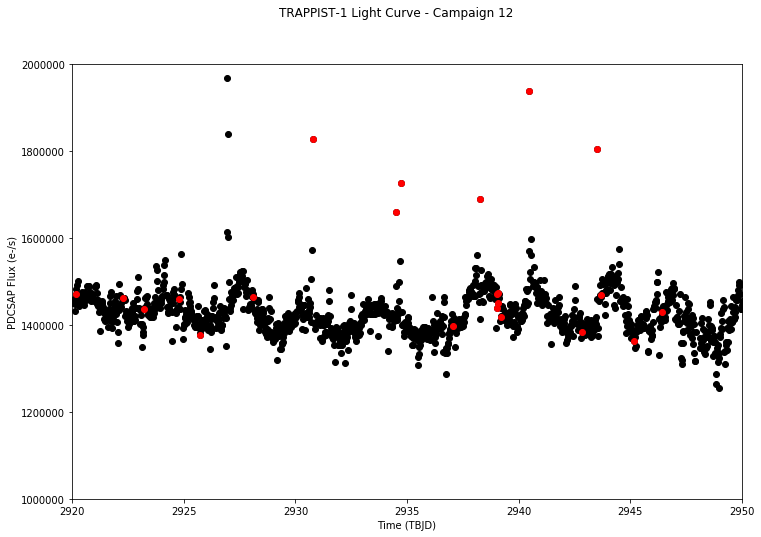

In [8]:
# Start figure and axis.
fig, ax = plt.subplots()
fig.set_size_inches(12., 8.)

# Plot the timeseries in black circles.
ax.plot(k2_bjds, pdcsap_fluxes, 'ko')

# Locate quality flags greater than zero.
where_gt0 = np.where(qual_flags > 0)[0]

# Overplot the fluxes with quality flags greater than zero in red.
ax.plot(k2_bjds[where_gt0], pdcsap_fluxes[where_gt0], 'ro')

# Let's zoom in on the x-axis and y-axis.
ax.set_xlim(2920., 2950.)
ax.set_ylim(0.1e7, 0.2e7)

# Let's label the axes and define a title for the figure.
fig.suptitle("TRAPPIST-1 Light Curve - Campaign 12")
ax.set_ylabel("PDCSAP Flux (e-/s)")
ax.set_xlabel("Time (TBJD)")
plt.show()

Intriguingly, some of the largest outliers in the positive flux direction are flagged: are these bad measurements that should be excised from the time series?  Finding out the quality flag value and converting the value to its consitutent bit masks to understand why these points are flagged would be the first step.  We encourage you to do this as a follow-up to this tutorial.

## Displaying The Aperture Pixel Information

Let's read in the second FITS extension HDU to display the aperture information.  First, let's read in the aperture pixels from the HDU.

In [9]:
with fits.open(fits_file, mode="readonly") as hdulist:
    aperture = hdulist[2].data

Let's plot the pixels as an image.

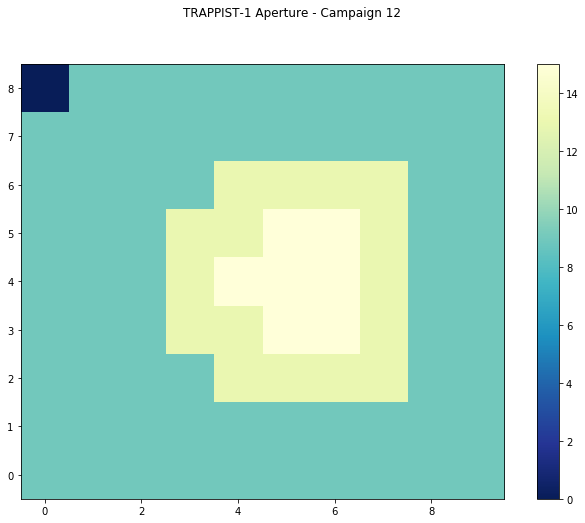

In [10]:
# Start figure and axis.
fig, ax = plt.subplots()
fig.set_size_inches(12., 8.)

# Display the pixels as an image.
cax = ax.imshow(aperture, cmap=plt.cm.YlGnBu_r, origin="lower")

# Add a color bar.
cbar = fig.colorbar(cax)

# Add a title to the plot.
fig.suptitle("TRAPPIST-1 Aperture - Campaign 12")
plt.show()

## Understanding The Aperture Pixel Values

We see the pixel values are integers, but what do they mean?  The pixels are bitmasks that encode information about each pixel.  You can find a summary of what the different values mean [here](https://archive.stsci.edu/kepler/manuals/archive_manual.pdf#page=20).  For example, a pixel in the aperture that might have a value of 15 can be broken down into power of 2 like: 8+4+2+1 = 15.  Referencing the table of values, this means this particular pixel was used to calculate the Pixel Response Function (PRF) centroid, was used to calculate the flux weighted centroid, was part of the optimal photometric aperture, and was collected by the spacecraft.  Numpy has a bulit-in function that can convert an integer into a binary bit mask.  Let's use that now on one of the common values we see in our displayed image above.

In [11]:
# Break down a pixel value of 267 (yellow pixels displayed above) into its
# constituent bits.
bitmask = np.binary_repr(15)
print(bitmask)

1111


Binary bits start from the right and end at the left, so the bit farthest on the right is the Least Significant Bit (LSB, equal to 2^0 = 1), the second from the right is 2^1=2, the third from the right is 2^2=4, etc.  This bit mask has bit values of 1 (2^0), 2 (2^1), 4 (2^2), and 8 (2^3) set.  If any were not set, there would be a zero in that position instead of a one.

## About this Notebook

**Author:** Scott W. Fleming, STScI Archive Scientist

**Updated On:** 2019-02-01

[Top of Page](#title_ID)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="STScI logo" width="200px"/> 